# Generating compounds given actives (29 novel molecules generated, given 12 actives)
## Author : Manas Mahale < <manas.mahale@bcp.edu.in>>

In [17]:
import re
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
from tqdm import trange
IPythonConsole.molSize = (800, 800)
IPythonConsole.ipython_useSVG = True  

from model.utils import set_seed
from model.model import GPT, GPTConfig
from model.trainer import Trainer, TrainerConfig
from model.utils import sample

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset

import pandas as pd
import numpy as np

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("./mmp12.csv")

In [4]:
df = df[df.pIC50_MMP12 != "Inactive"]
df.pIC50_MMP12 = df.pIC50_MMP12.astype(float)
df = df[df.pIC50_MMP12 > 7.5]

In [5]:
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        chars = []
        for i in text:
            for j in set(i):
                chars.append(j)           
        chars = sorted(list(set(chars))) + ['<pad>']
        data_size, vocab_size = len(text), len(chars)
        print('Data has %d SMILES \n%d unique characters.' % (data_size, vocab_size))        
        self.stoi = {ch:i for i,ch in enumerate(chars)}
        self.itos = {i:ch for i,ch in enumerate(chars)}
        self.vocab_size = vocab_size
        self.data = data
        self.block_size = block_size
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + 1][0]
        dix = [self.stoi[s] for s in chunk] + [self.stoi['<pad>']] * (self.block_size - len(chunk))
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [6]:
block_size = 68
text = df.Smiles.to_list()
train_dataset = CharDataset(text, block_size)

Data has 12 SMILES 
17 unique characters.


In [7]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=2, n_head=2, n_embd=128)
model = GPT(mconf)

In [ ]:
tconf = TrainerConfig(max_epochs=1000, batch_size=12, learning_rate=6e-5,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()

In [ ]:
a = []
context = "C"
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
for _ in trange(50):
    y = sample(model, x, 200, temperature=1.0, sample=True, top_k=10)[0]
    completion = ''.join([train_dataset.itos[int(i)] for i in y])

    smiles = re.sub("<pad>","",completion)
    m = Chem.MolFromSmiles(smiles)
    if m is not None:
        a.append(m)

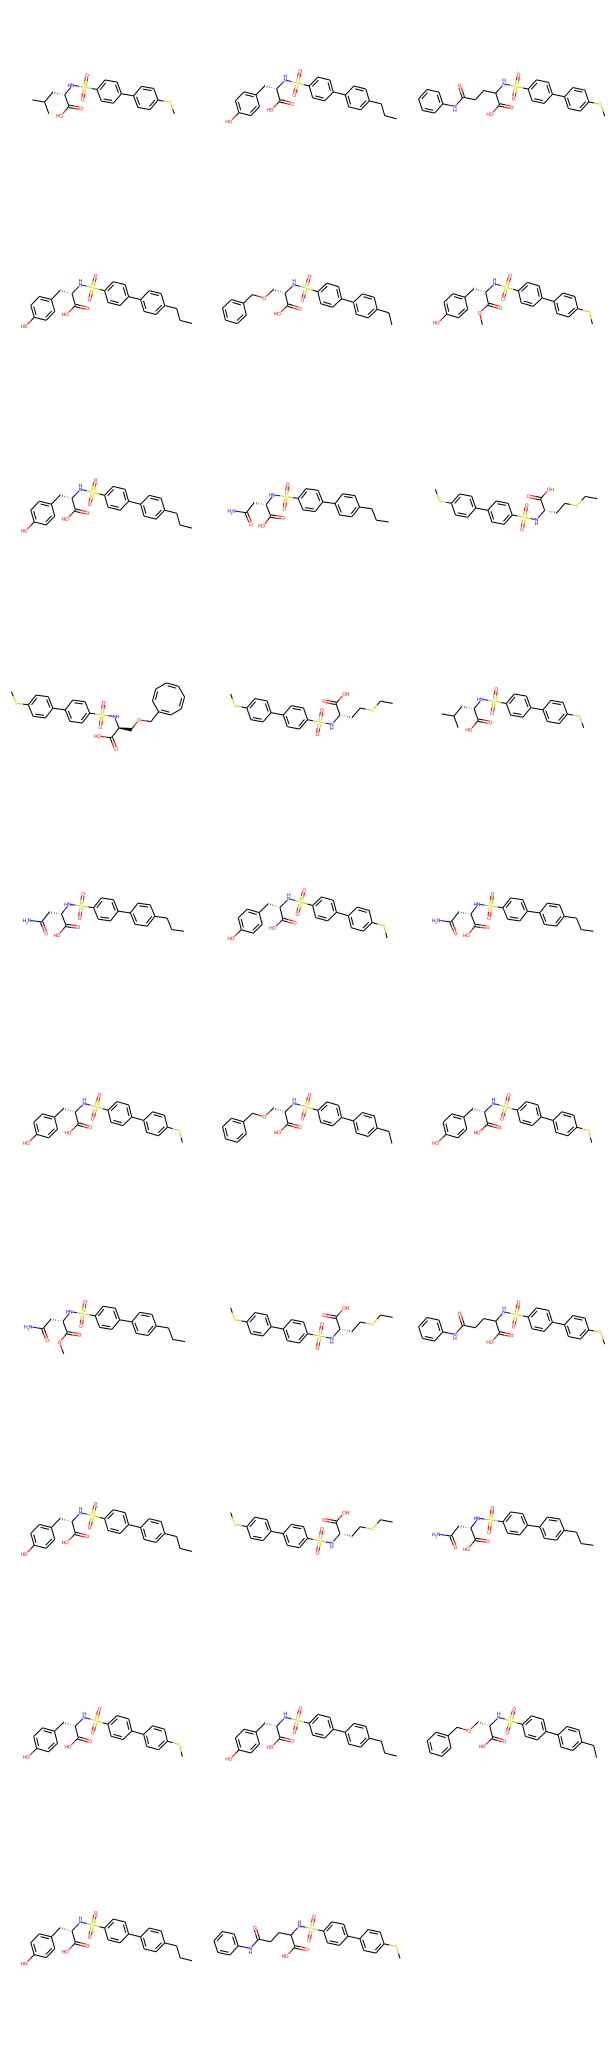

In [63]:
Chem.Draw.MolsToGridImage(a, subImgSize=(400, 400))